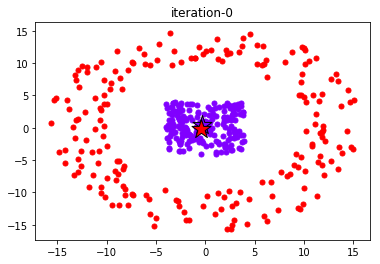

('Cluster member numbers-', 0, ': ', 200)
('Cluster member numbers-', 1, ': ', 200)
('iteration-', 1, ': ', 17.0, ' seconds')


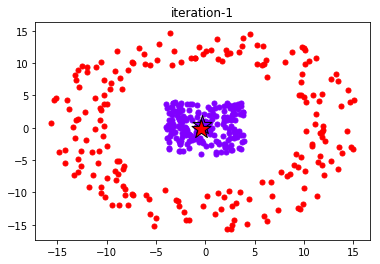

('Cluster member numbers-', 0, ': ', 200)
('Cluster member numbers-', 1, ': ', 200)


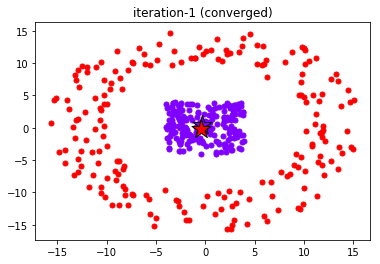

converged!


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
import time

filePath1 = "test1_data.txt"
filePath2 = "test2_data.txt"
dataTesting1 = np.loadtxt(filePath1, delimiter=" ")
dataTesting2 = np.loadtxt(filePath2, delimiter=" ")

#params
k = 2 #number of cluster
var = 5 #var in RFB kernel
iterationCounter = 0
input = dataTesting2
initMethod = "byOriginDistance" #options = random, byCenterDistance, byOriginDistance

def initCluster(dataInput, nCluster, method):
    listClusterMember = [[] for i in range(nCluster)]
    if (method == "random"):
        shuffledDataIn = dataInput
        np.random.shuffle(shuffledDataIn)
        for i in range(0, dataInput.shape[0]):
            listClusterMember[i%nCluster].append(dataInput[i,:])
    if (method == "byCenterDistance"):
        center = np.matrix(np.mean(dataInput, axis=0))
        repeatedCent = np.repeat(center, dataInput.shape[0], axis=0)
        deltaMatrix = abs(np.subtract(dataInput, repeatedCent))
        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
        dataNew = np.array(np.concatenate((euclideanMatrix, dataInput), axis=1))
        dataNew = dataNew[np.argsort(dataNew[:, 0])]
        dataNew = np.delete(dataNew, 0, 1)
        divider = dataInput.shape[0]/nCluster
        for i in range(0, dataInput.shape[0]):
            listClusterMember[np.int(np.floor(i/divider))].append(dataNew[i,:])
    if (method == "byOriginDistance"):
        origin = np.matrix([[0,0]])
        repeatedCent = np.repeat(origin, dataInput.shape[0], axis=0)
        deltaMatrix = abs(np.subtract(dataInput, repeatedCent))
        euclideanMatrix = np.sqrt(np.square(deltaMatrix).sum(axis=1))
        dataNew = np.array(np.concatenate((euclideanMatrix, dataInput), axis=1))
        dataNew = dataNew[np.argsort(dataNew[:, 0])]
        dataNew = np.delete(dataNew, 0, 1)
        divider = dataInput.shape[0]/nCluster
        for i in range(0, dataInput.shape[0]):
            listClusterMember[np.int(np.floor(i/divider))].append(dataNew[i,:])

    return listClusterMember

def RbfKernel(data1, data2, sigma):
    delta =abs(np.subtract(data1, data2))
    squaredEuclidean = (np.square(delta).sum(axis=1))
    result = np.exp(-(squaredEuclidean)/(2*sigma**2))
    return result

def thirdTerm(memberCluster):
    result = 0
    for i in range(0, memberCluster.shape[0]):
        for j in range(0, memberCluster.shape[0]):
            result = result + RbfKernel(memberCluster[i, :], memberCluster[j, :], var)
    result = result / (memberCluster.shape[0] ** 2)
    return result

def secondTerm(dataI, memberCluster):
    result = 0
    for i in range(0, memberCluster.shape[0]):
        result = result + RbfKernel(dataI, memberCluster[i,:], var)
    result = 2 * result / memberCluster.shape[0]
    return result

def plotResult(listClusterMembers, centroid, iteration, converged):
    n = listClusterMembers.__len__()
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    plt.figure("result")
    plt.clf()
    plt.title("iteration-" + iteration)
    for i in range(n):
        col = next(color)
        memberCluster = np.asmatrix(listClusterMembers[i])
        plt.scatter(np.ravel(memberCluster[:, 0]), np.ravel(memberCluster[:, 1]), marker=".", s=100, c=col)
    color = iter(cm.rainbow(np.linspace(0, 1, n)))
    for i in range(n):
        col = next(color)
        plt.scatter(np.ravel(centroid[i, 0]), np.ravel(centroid[i, 1]), marker="*", s=400, c=col, edgecolors="black")
    if (converged == 0):
        plt.ion()
        plt.show()
        plt.pause(0.1)
    if (converged == 1):
        plt.show(block=True)

def kMeansKernel(data, initMethod):
    global iterationCounter
    memberInit = initCluster(data, k, initMethod)
    nCluster = memberInit.__len__()
    #looping until converged
    while(True):
        # calculate centroid, only for visualization purpose
        centroid = np.ndarray(shape=(0, data.shape[1]))
        for i in range(0, nCluster):
            memberCluster = np.asmatrix(memberInit[i])
            centroidCluster = memberCluster.mean(axis=0)
            centroid = np.concatenate((centroid, centroidCluster), axis=0)
        #plot result in every iteration
        plotResult(memberInit, centroid, str(iterationCounter), 0)
        oldTime = np.around(time.time(), decimals=0)
        kernelResultClusterAllCluster = np.ndarray(shape=(data.shape[0], 0))
        #assign data to cluster whose centroid is the closest one
        for i in range(0, nCluster):#repeat for all cluster
            term3 = thirdTerm(np.asmatrix(memberInit[i]))
            matrixTerm3 = np.repeat(term3, data.shape[0], axis=0); matrixTerm3 = np.asmatrix(matrixTerm3)
            matrixTerm2 = np.ndarray(shape=(0,1))
            for j in range(0, data.shape[0]): #repeat for all data
                term2 = secondTerm(data[j,:], np.asmatrix(memberInit[i]))
                matrixTerm2 = np.concatenate((matrixTerm2, term2), axis=0)
            matrixTerm2 = np.asmatrix(matrixTerm2)
            kernelResultClusterI = np.add(-1*matrixTerm2, matrixTerm3)
            kernelResultClusterAllCluster =\
                np.concatenate((kernelResultClusterAllCluster, kernelResultClusterI), axis=1)
        clusterMatrix = np.ravel(np.argmin(np.matrix(kernelResultClusterAllCluster), axis=1))
        listClusterMember = [[] for l in range(k)]
        for i in range(0, data.shape[0]):#assign data to cluster regarding cluster matrix
            listClusterMember[np.asscalar(clusterMatrix[i])].append(data[i,:])
        for i in range(0, nCluster):
            print("Cluster member numbers-", i, ": ", listClusterMember[0].__len__())
        #break when converged
        boolAcc = True
        for m in range(0, nCluster):
            prev = np.asmatrix(memberInit[m])
            current = np.asmatrix(listClusterMember[m])
            if (prev.shape[0] != current.shape[0]):
                boolAcc = False
                break
            if (prev.shape[0] == current.shape[0]):
                boolPerCluster = (prev == current).all()
            boolAcc = boolAcc and boolPerCluster
            if(boolAcc==False):
                break
        if(boolAcc==True):
            break
        iterationCounter += 1
        #update new cluster member
        memberInit = listClusterMember
        newTime = np.around(time.time(), decimals=0)
        print("iteration-", iterationCounter, ": ", newTime - oldTime, " seconds")
    return listClusterMember, centroid

clusterResult, centroid = kMeansKernel(input, initMethod)
plotResult(clusterResult, centroid, str(iterationCounter) + ' (converged)', 1)
print("converged!")
